In [1]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

In [6]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit.append(simon_oracle(b), range(6))

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌───┐ ░ ┌──────────────┐ ░ ┌───┐┌─┐      
q_0: ┤ H ├─░─┤0             ├─░─┤ H ├┤M├──────
     ├───┤ ░ │              │ ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░─┤1             ├─░─┤ H ├─╫─┤M├───
     ├───┤ ░ │              │ ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░─┤2             ├─░─┤ H ├─╫──╫─┤M├
     └───┘ ░ │  circuit-102 │ ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤3             ├─░───────╫──╫──╫─
           ░ │              │ ░       ║  ║  ║ 
q_4: ──────░─┤4             ├─░───────╫──╫──╫─
           ░ │              │ ░       ║  ║  ║ 
q_5: ──────░─┤5             ├─░───────╫──╫──╫─
           ░ └──────────────┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════╩══╩══╩═
                                      0  1  2

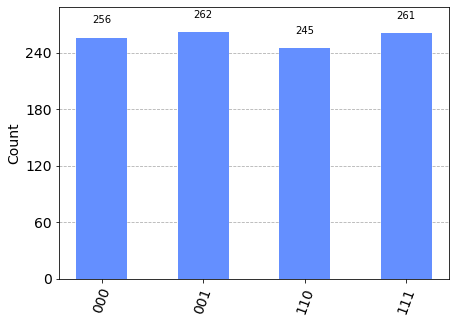

In [11]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
#shots = 1024
qobj = transpile(simon_circuit, aer_sim)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [14]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

# Query oracle
simon_circuit_2.append(simon_oracle(b), range(2*n))

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()

┌───┐┌──────────────┐┌───┐┌─┐   
q_0: ┤ H ├┤0             ├┤ H ├┤M├───
     ├───┤│              │├───┤└╥┘┌─┐
q_1: ┤ H ├┤1             ├┤ H ├─╫─┤M├
     └───┘│  circuit-112 │└───┘ ║ └╥┘
q_2: ─────┤2             ├──────╫──╫─
          │              │      ║  ║ 
q_3: ─────┤3             ├──────╫──╫─
          └──────────────┘      ║  ║ 
c: 2/═══════════════════════════╩══╩═
                                0  1

In [15]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n*2 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

<ipython-input-15-9a1e4d2aaf40>:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


least busy backend:  ibmq_belem


<ipython-input-15-9a1e4d2aaf40>:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


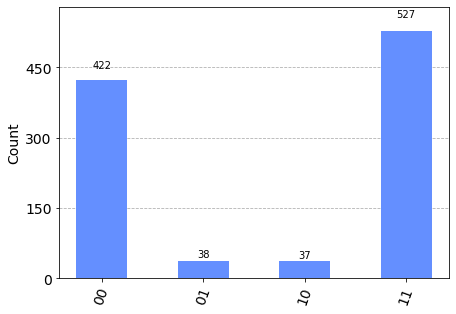

In [16]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [17]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

b = 11
11.00 = 0 (mod 2) (41.2%)
11.01 = 1 (mod 2) (3.7%)
11.10 = 1 (mod 2) (3.6%)
11.11 = 0 (mod 2) (51.5%)


In [18]:
import qiskit.tools.jupyter
%qiskit_version_table